In [1]:
import os
import sys
import torch as th
from time import time

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

from params import default_params

# ------------------------- ENVIRONMENTS ---------------------------
from environments.environment_tsp import EnviornmentTSP
# ----------------------------------------------------------------

# ------------------------- NETWORKS -------------------------------
from networks.attention_encoder_decoder import LightAttentionEncoderDecoder
# ----------------------------------------------------------------

# ------------------------- EXPERIMENTS ----------------------------
from experiments.actor_critic_experiment import ActorCriticExperiment
# ----------------------------------------------------------------

# ------------------------- CONTROLLERS ----------------------
from controllers.ac_controller import ActorCriticController
# ------------------------------------------------------------------

# ------------------------- LEARNERS --------------------------------
from learners.biased_reinforce_learner import BiasedReinforceLearner
from learners.actor_critic_learner import ActorCriticLearner
from learners.ppo_learner import PPOLearner
# ------------------------------------------------------------------

# -------------------------- GENERATORS ----------------------------
from generators.tsp_generator import TSPGenerator
# ------------------------------------------------------------------

# -------------------------- SOLVERS ----------------------------
from solvers.gurobi_tsp import solve_tsp
# ------------------------------------------------------------------

In [2]:
params = default_params()

# Debugging outputs and plotting during training
params['plot_frequency'] = 10
params['plot_train_samples'] = True
params['debug_messages'] = False
params['print_dots'] = False

# Environment parameters
max_nodes_per_graph = 10
params['env'] = 'tsp'
params['node_dimension'] = 2
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['diff_cities'] = True
params['use_training_set'] = False
params['training_sizes'] = [max_nodes_per_graph]
params['num_train_instance_per_size'] = 10
params['cities'] = None

# Runner parameters
max_episodes = 3000
rollouts_per_batch = 50
params['max_episodes'] = max_episodes
params['max_steps'] = params['max_episodes'] * params['max_episode_length'] * rollouts_per_batch
params['multi_runner'] = False               
params['parallel_environments'] = 2  

# Exploration parameters
pct_epsilon_anneal_time = 0.8
params['use_epsilon_greedy'] = False
params['epsilon_anneal_time'] =  pct_epsilon_anneal_time * params['max_steps']
params['epsilon_finish'] = 1E-5
params['epsilon_start'] = 1.0
params['epsilon_decay'] = "linear"

pct_entropy_anneal_time = 1.0
params['entropy_regularization'] = True
params['decay_entropy'] = True
params['entropy_weight'] = 0.1
params['entropy_weight_start'] = 1.0
params['entropy_weight_end'] = 0.01
params['entropy_anneal_time'] = pct_entropy_anneal_time * params['max_episodes']

# Optimization parameters
params['lr'] = 5E-4
params['gamma'] = 0.99
params['batch_size'] = params['max_episode_length'] * rollouts_per_batch
params['grad_norm_clip'] = 1

# Actor-critic parameters
params['value_loss_param'] = 0.1
params['advantage_bias'] = True
params['advantage_bootstrap'] = True
params['offpolicy_iterations'] = 10
params['value_targets'] = 'td'

# PPO parameters
params['ppo_clipping'] = True
params['ppo_clip_eps'] = 0.1

# Network parameters
params['embedding_dimension'] = 4                                    
params['n_heads'] = 4               
params['n_layers'] = 3 
params['normalization'] = 'batch'
params['feed_forward_hidden'] = 512      

# Device
# params['device'] = "cuda" if th.cuda.is_available() else "cpu"
# th.device(params['device'])
params['device'] = 'cpu'
params['use_tqdm'] = False
params['final_plot'] = False
params['wandb'] = False

print("Device in use: ", params['device'])
print("Epsilon anneal time: ", params['epsilon_anneal_time'])
print("Entropy anneal episodes: ", params['entropy_anneal_time'])
print("Total transitions: ", params['max_steps'])

Device in use:  cpu
Epsilon anneal time:  1320000.0
Entropy anneal episodes:  3000.0
Total transitions:  1650000


## PPOLearner

In [3]:
model = LightAttentionEncoderDecoder(params=params)
env = EnviornmentTSP(params=params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, PPOLearner(model=model, params=params))

In [4]:
metadata = experiment.guroby_vs_greedy_rollout(sizes=params['training_sizes'], num_episodes_per_size=20, plot = False)
print(f"Average gap: {metadata['avg_gap']}%")

Restricted license - for non-production use only - expires 2025-11-24
Average gap: 81.24%


In [5]:
metadata = experiment.guroby_vs_best_sample(sizes=params['training_sizes'], num_episodes_per_size=100, runs_per_episode=10, plot=False)
print(f"Average gap: {metadata['avg_gap']}%")

Average gap: 48.66%


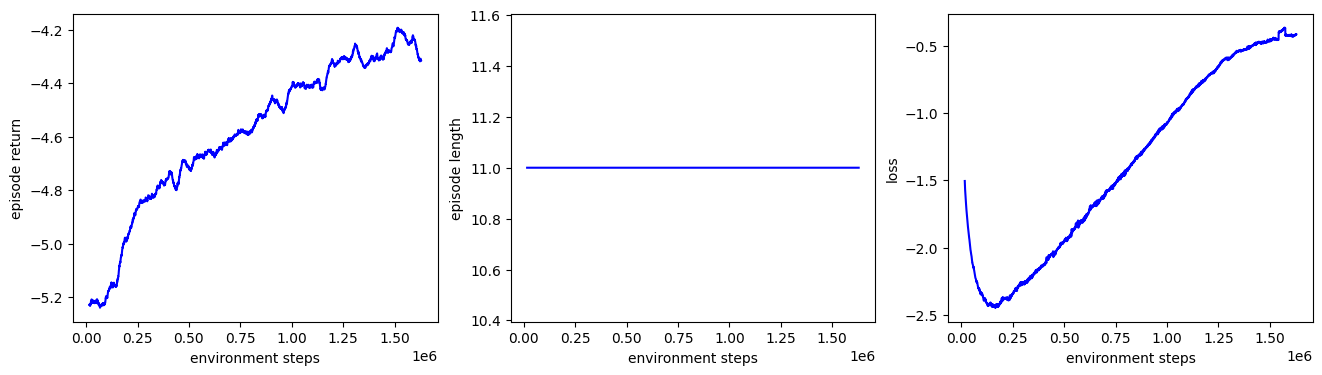

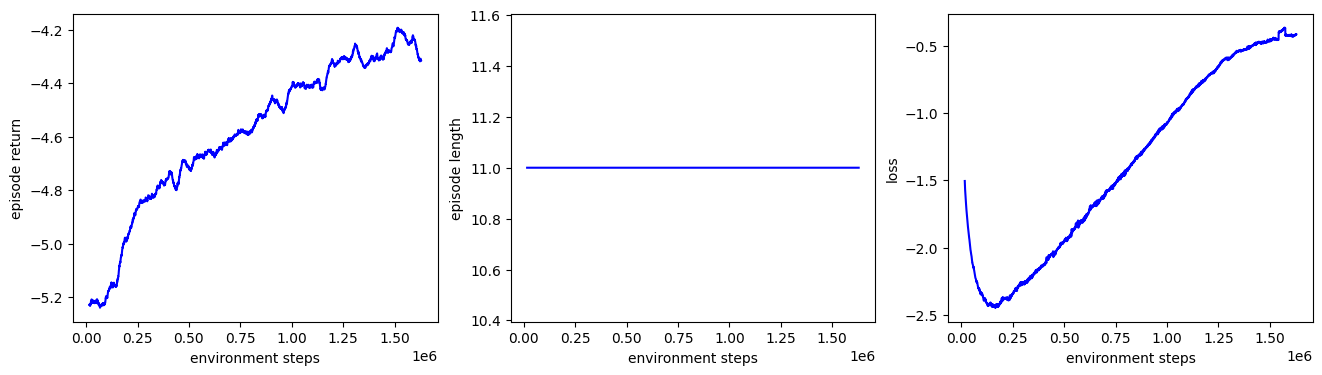

In [6]:
start = time()
experiment.run()
end = time()
total_time = end - start

In [7]:
print("Total spended time in experiment: ", total_time)

Total spended time in experiment:  8059.457818746567


Tour distance: 5.574365615844727


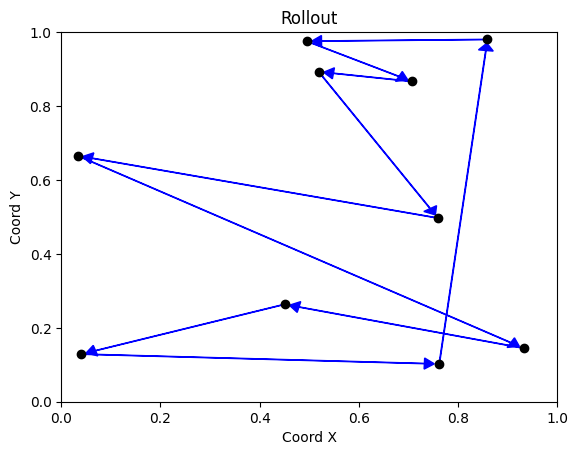

In [13]:
experiment.plot_rollout()

In [9]:
metadata = experiment.guroby_vs_greedy_rollout(sizes=params['training_sizes'], num_episodes_per_size=100, plot=False)
print(f"Average gap: {metadata['avg_gap']}%")

Average gap: 53.76%


In [10]:
metadata = experiment.guroby_vs_best_sample(sizes=params['training_sizes'], num_episodes_per_size=100, runs_per_episode=10, plot=False)
print(f"Average gap: {metadata['avg_gap']}%")

Average gap: 35.04%
